# Analysis script
## import packages and load data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import math
import glob
from datetime import datetime
from scipy import stats

In [2]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [3]:
path = '/content/drive/MyDrive/Thesis/Data/'
data = pd.read_csv(os.path.join(path, 'TrainImageSample2000.csv'))

data.columns

Index(['VV', 'VH', 'angle', 'ice', 'lake', 'windU', 'windV', 'cont', 'corr',
       'ent', 'VVwindowVar', 'VHwindowVar', 'pixelId', 'imgId', 'Date',
       'country', 'month', 'VV/VH', 'windRes', 'windDir'],
      dtype='object')

In [4]:
data['Date'] =  pd.to_datetime(data['Date'], format='%Y-%m-%d %H:%M:%S')
data['Date'] = data.Date.dt.round('1s')
data['year'] = data.Date.dt.to_period('Y')

data.loc[data.ice == 1, 'iceplot'] = 'Ice'
data.loc[data.ice == 0, 'iceplot'] = 'Water'

data.head()

,VV,VH,angle,ice,lake,windU,windV,cont,corr,ent,...,pixelId,imgId,Date,country,month,VV/VH,windRes,windDir,year,iceplot
0,-25.610180,-32.770473,35.804420,0,1,1.676041,2.994339,1047.055176,0.660649,4.168513,...,3779274,170,2018-09-30 04:49:05,Finland,2018-09,0.781502,5.803451,209.237329,2018,Water
1,-21.608246,-28.077782,36.051094,0,1,1.709244,2.948441,154.628479,0.501768,4.229198,...,2316635,170,2018-09-30 04:49:05,Finland,2018-09,0.769585,5.869955,210.101346,2018,Water
2,-18.697680,-24.187178,35.815872,0,1,1.676041,2.994339,1436.851562,0.769786,4.342926,...,3745241,170,2018-09-30 04:49:05,Finland,2018-09,0.773041,5.803451,209.237329,2018,Water
3,-19.537649,-27.114115,36.027145,0,1,1.709244,2.948441,175.116760,0.706706,4.099168,...,1112834,170,2018-09-30 04:49:05,Finland,2018-09,0.720571,5.869955,210.101346,2018,Water
4,-26.375553,-30.735609,36.068623,0,1,1.709244,2.948441,946.104614,0.581719,4.281530,...,2344576,170,2018-09-30 04:49:05,Finland,2018-09,0.858143,5.869955,210.101346,2018,Water


In [5]:
print('shape data before dropping na', data.shape)
data = data.dropna()
print('shape data after dropping na', data.shape)


shape data before dropping na (950000, 22)
shape data after dropping na (945687, 22)


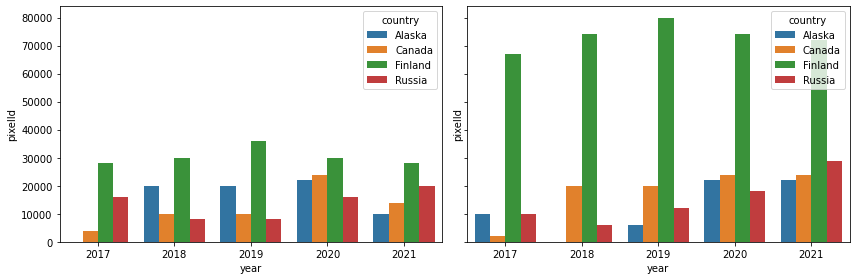

In [6]:
timeViz = data.copy()
timeViz = timeViz.groupby(['country', 'ice', 'year'], as_index = False).pixelId.count()
timeViz['year'] = timeViz['year'].astype(str)
yearorder = ['2017', '2018', '2019', '2020', '2021']

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4), sharey=True, sharex = True)

sns.barplot(x="year", y="pixelId", hue="country", data=timeViz[timeViz['ice']==1], ax = ax1, order = yearorder)
sns.barplot(x="year", y="pixelId", hue="country", data=timeViz[timeViz['ice']==0], ax = ax2, order = yearorder)

plt.tight_layout()

In [7]:
dataNotFinland = data[data['country'] != 'Finland']
dataFinland = data[data['country'] == 'Finland']
n = timeViz[timeViz['country'] == 'Finland'].pixelId.min()
dataFinland = dataFinland.groupby(['year', 'ice']).sample(n = n)

dataResampled = pd.concat([dataNotFinland, dataFinland], ignore_index = True)

dataResampled.shape

(706708, 22)

## outlier detection

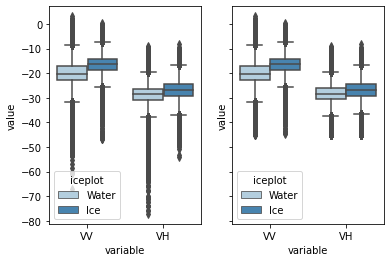

In [8]:
boxplotData = dataResampled.copy()
boxplotData = boxplotData[['country', 'VV', 'VH', 'iceplot', 'pixelId', 'imgId']]
boxplotData = pd.melt(boxplotData, id_vars= ['pixelId', 'imgId', 'iceplot', 'country'], value_vars=['VV', 'VH'])

fig, (ax1, ax2) = plt.subplots(1,2, sharey = True)

sns.boxplot(x="variable", y="value", hue="iceplot", data=boxplotData, palette="Blues", ax = ax1)
sns.boxplot(x="variable", y="value", hue="iceplot", data=boxplotData[boxplotData['value'] > -45], palette="Blues", ax=ax2)

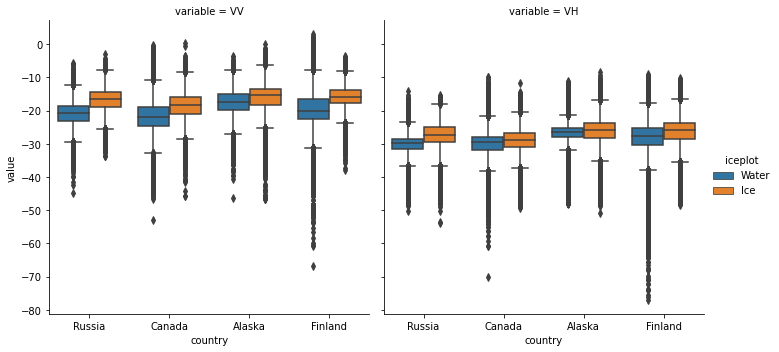

In [9]:
sns.catplot(x="country", y="value",
                hue="iceplot", col="variable",
                data=boxplotData, kind="box", height = 5)

𝑂𝑢𝑡𝑙𝑖𝑒𝑟=[𝑄1−𝑘(𝑄3−𝑄1),𝑄3+𝑘(𝑄3−𝑄1)] 

In [10]:
def tuckey_fences(df, column, k):
  quants = pd.DataFrame(df[column].quantile([0.25,0.75]))
  Q1 = quants.iloc[0,0]
  Q3 = quants.iloc[1,0]

  lowerBound = Q1-(k*(Q3-Q1))
  upperBound = Q1+(k*(Q3-Q1))

  data = df[df[column].between(lowerBound, upperBound)]
  return data 

tuckey = dataResampled.copy()
for col in ['VV', 'VH', 'cont', 'ent']:
  tuckey = tuckey_fences(tuckey, col, 3)

print(dataResampled.shape)
print(tuckey.shape)


(706708, 22)
(659748, 22)


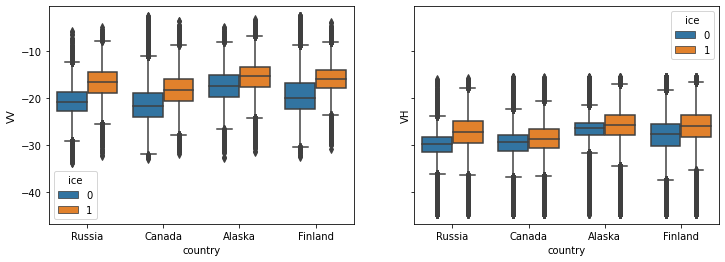

In [11]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4), sharey=True)

sns.boxplot(x='country', y = 'VV', hue ='ice', data = tuckey, ax =ax1)
sns.boxplot(x='country', y = 'VH', hue ='ice', data = tuckey, ax =ax2)


## Visualize data

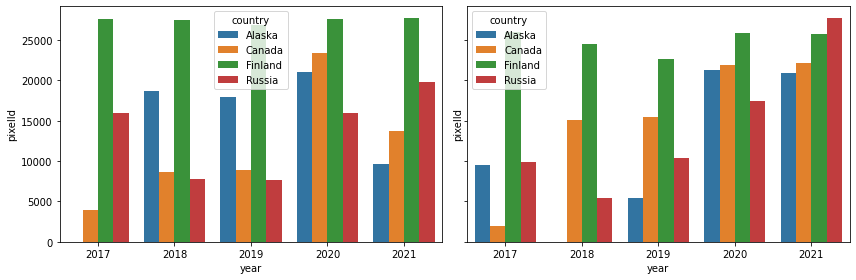

In [12]:
timeViz = tuckey.copy()
timeViz = timeViz.groupby(['country', 'ice', 'year'], as_index = False).pixelId.count()
timeViz['year'] = timeViz['year'].astype(str)
yearorder = ['2017', '2018', '2019', '2020', '2021']

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4), sharey=True, sharex = True)

sns.barplot(x="year", y="pixelId", hue="country", data=timeViz[timeViz['ice']==1], ax = ax1, order = yearorder)
sns.barplot(x="year", y="pixelId", hue="country", data=timeViz[timeViz['ice']==0], ax = ax2, order = yearorder)

plt.tight_layout()

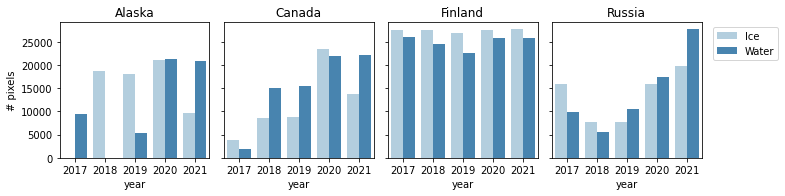

In [13]:
timeViz = tuckey.copy()
timeViz = timeViz.groupby(['country', 'iceplot', 'year'], as_index = False).pixelId.count()
timeViz['year'] = timeViz['year'].astype(str)
yearorder = ['2017', '2018', '2019', '2020', '2021']

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (11,3), sharey=True, sharex = True)

sns.barplot(x="year", y="pixelId", hue="iceplot", data=timeViz[timeViz['country']=='Alaska'], ax = ax1, order = yearorder, palette="Blues")
sns.barplot(x="year", y="pixelId", hue="iceplot", data=timeViz[timeViz['country']=='Canada'], ax = ax2, order = yearorder, palette="Blues")
sns.barplot(x="year", y="pixelId", hue="iceplot", data=timeViz[timeViz['country']=='Finland'], ax = ax3, order = yearorder, palette="Blues")
sns.barplot(x="year", y="pixelId", hue="iceplot", data=timeViz[timeViz['country']=='Russia'], ax = ax4, order = yearorder, palette="Blues")

ax1.set_title('Alaska')
ax2.set_title('Canada')
ax3.set_title('Finland')
ax4.set_title('Russia')

#ax4.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax1.get_legend().remove()
ax2.get_legend().remove()
ax3.get_legend().remove()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

ax1.set_ylabel('# pixels')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')

fig.tight_layout()
fig.subplots_adjust(top=0.82)

plt.show()

fig.savefig('datadistribution.png')

### Normalize 

In [14]:
tuckey['VVnorm'] = stats.zscore(tuckey['VV'])
tuckey['VHnorm'] = stats.zscore(tuckey['VH'])

def min_max_normalization(col):
  min = col.min()
  max = col.max()
  colMinMax = ((col-min)/(max-min))
  return colMinMax

#tuckey['VVnorm'] = min_max_normalization(tuckey['VV'])
#tuckey['VHnorm'] = min_max_normalization(tuckey['VH'])


Text(0.5, 1.0, 'VV/VH')

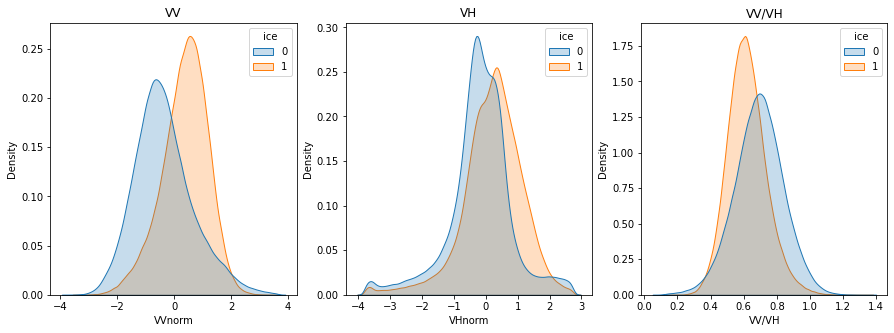

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize = (15, 5), sharey = False)

sns.kdeplot(ax = ax1, data = tuckey, x = 'VVnorm', hue = 'ice', fill = True)
sns.kdeplot(ax = ax2, data = tuckey, x = 'VHnorm', hue = 'ice', fill = True)
sns.kdeplot(ax = ax3, data = tuckey, x = 'VV/VH', hue = 'ice', fill = True)

ax1.set_title('VV')
ax2.set_title('VH')
ax3.set_title('VV/VH')

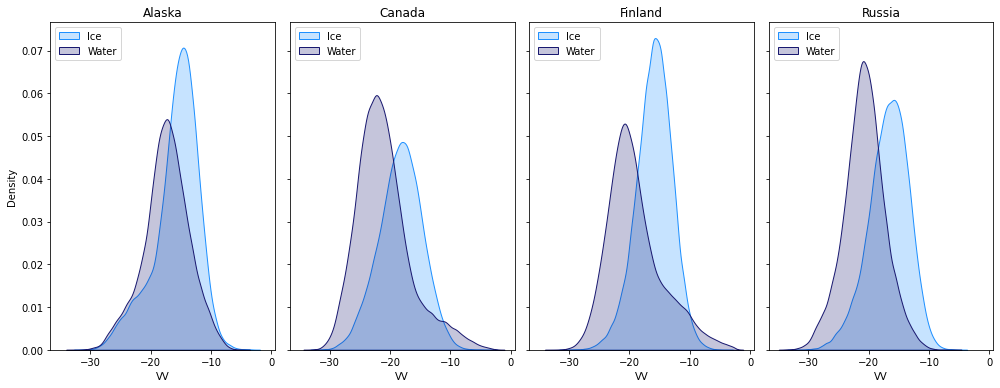

In [16]:
my_pal = {"Water": "midnightblue", "Ice": "dodgerblue"}

fig, (ax1, ax2,ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize = (14,5.5), sharey = True, sharex = True)

sns.kdeplot(ax = ax1, data = tuckey[tuckey['country'] == 'Alaska'], x = 'VV', hue = 'iceplot', fill = True, palette = my_pal)
sns.kdeplot(ax = ax2, data = tuckey[tuckey['country'] == 'Canada'], x = 'VV', hue = 'iceplot', fill = True, palette = my_pal)
sns.kdeplot(ax = ax3, data = tuckey[tuckey['country'] == 'Finland'], x = 'VV', hue = 'iceplot', fill = True, palette = my_pal)
sns.kdeplot(ax = ax4, data = tuckey[tuckey['country'] == 'Russia'], x = 'VV', hue = 'iceplot', fill = True, palette = my_pal)


ax1.set_title('Alaska')
ax2.set_title('Canada')
ax3.set_title('Finland')
ax4.set_title('Russia')

ax1.set_xlabel('VV')
ax2.set_xlabel('VV')
ax3.set_xlabel('VV')
ax4.set_xlabel('VV')

ax1.legend(labels=["Ice","Water"], loc='upper left')
ax2.legend(labels=["Ice","Water"], loc='upper left')
ax3.legend(labels=["Ice","Water"], loc='upper left')
ax4.legend(labels=["Ice","Water"], loc='upper left')

fig.tight_layout()
plt.show()

fig.savefig('VVDensityPerCountry.png')

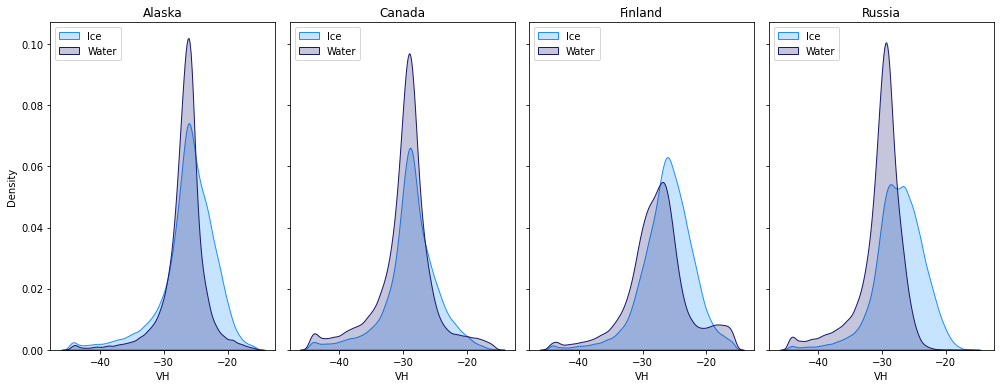

In [17]:
my_pal = {"Water": "midnightblue", "Ice": "dodgerblue"}

fig, (ax1, ax2,ax3, ax4) = plt.subplots(ncols=4, nrows=1, figsize = (14,5.5), sharey = True, sharex = True)

sns.kdeplot(ax = ax1, data = tuckey[tuckey['country'] == 'Alaska'], x = 'VH', hue = 'iceplot', fill = True, palette = my_pal)
sns.kdeplot(ax = ax2, data = tuckey[tuckey['country'] == 'Canada'], x = 'VH', hue = 'iceplot', fill = True, palette = my_pal)
sns.kdeplot(ax = ax3, data = tuckey[tuckey['country'] == 'Finland'], x = 'VH', hue = 'iceplot', fill = True, palette = my_pal)
sns.kdeplot(ax = ax4, data = tuckey[tuckey['country'] == 'Russia'], x = 'VH', hue = 'iceplot', fill = True, palette = my_pal)


ax1.set_title('Alaska')
ax2.set_title('Canada')
ax3.set_title('Finland')
ax4.set_title('Russia')

ax1.set_xlabel('VH')
ax2.set_xlabel('VH')
ax3.set_xlabel('VH')
ax4.set_xlabel('VH')

ax1.legend(labels=["Ice","Water"], loc='upper left')
ax2.legend(labels=["Ice","Water"], loc='upper left')
ax3.legend(labels=["Ice","Water"], loc='upper left')
ax4.legend(labels=["Ice","Water"], loc='upper left')

fig.tight_layout()
plt.show()

fig.savefig('VHDensityPerCountry.png')

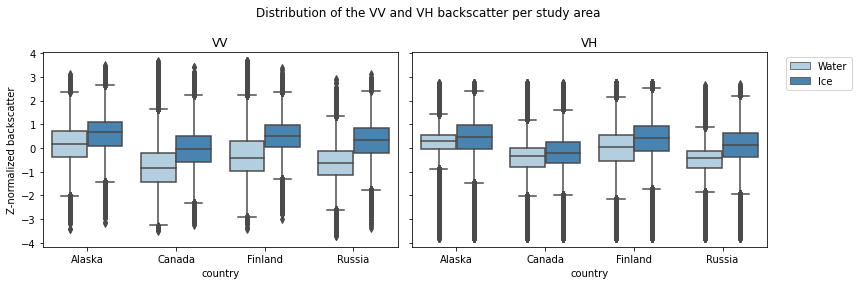

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (12,4), sharey=True)
country_order = ['Alaska', 'Canada', 'Finland', 'Russia']

sns.boxplot(x='country', y = 'VVnorm', hue ='iceplot', data = tuckey, ax =ax1, order = country_order, palette="Blues")
sns.boxplot(x='country', y = 'VHnorm', hue ='iceplot', data = tuckey, ax =ax2, order = country_order, palette="Blues")

ax1.get_legend().remove()
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

ax1.set_title('VV')
ax2.set_title('VH')

ax1.set_ylabel('Z-normalized backscatter')
ax2.set_ylabel('')

fig.suptitle('Distribution of the VV and VH backscatter per study area')
fig.tight_layout()
fig.subplots_adjust(top=0.82)

plt.show()

fig.savefig('backscatterDistribution.png')

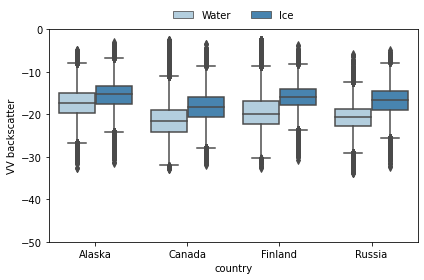

In [19]:
fig, ax = plt.subplots(1,1, figsize = (6,4), sharey=True)
country_order = ['Alaska', 'Canada', 'Finland', 'Russia']

sns.boxplot(x='country', y = 'VV', hue ='iceplot', data = tuckey, ax =ax, order = country_order, palette="Blues")
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

ax.set_ylabel('VV backscatter')
plt.ylim(-50, 0)
fig.tight_layout()
plt.show()

fig.savefig('boxplotVV.png')

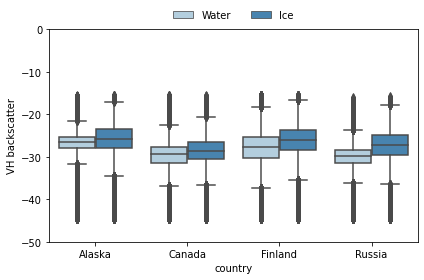

In [20]:
fig, ax = plt.subplots(1,1, figsize = (6,4), sharey=True)
country_order = ['Alaska', 'Canada', 'Finland', 'Russia']

sns.boxplot(x='country', y = 'VH', hue ='iceplot', data = tuckey, ax =ax, order = country_order, palette="Blues")
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

ax.set_ylabel('VH backscatter')
plt.ylim(-50, 0)

fig.tight_layout()
plt.show()

fig.savefig('boxplotVH.png')

## Wind visualisation

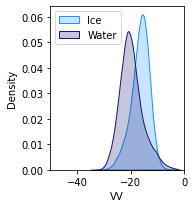

In [21]:
# wind analysis
windan = tuckey.copy()
windan = windan[['VV', 'VH', 'windRes', 'iceplot', 'country', 'windDir']]
windan['windRes'] = windan['windRes']/3.6

my_pal = {"Water": "midnightblue", "Ice": "dodgerblue"}

fig, ax = plt.subplots(1,1,  figsize = (2.8,3))
sns.kdeplot(data = windan[windan['windRes'] < 5], x = 'VV', hue = 'iceplot', fill = True, ax = ax, palette = my_pal)
plt.legend(labels=["Ice","Water"], loc='upper left')

ax.set_xlabel('VV')
plt.xlim(-50, 0)


fig.tight_layout()

plt.show()

fig.savefig('VVdistunder5.png')

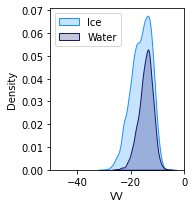

In [ ]:
my_pal = {"Water": "midnightblue", "Ice": "dodgerblue"}

fig, ax = plt.subplots(1,1,  figsize = (2.8,3))
sns.kdeplot(data = windan[windan['windRes'] > 10], x = 'VV', hue = 'iceplot', fill = True, ax = ax, palette = my_pal)
plt.legend(labels=["Ice","Water"], loc='upper left')

ax.set_xlabel('VV')
plt.xlim(-50, 0)

fig.tight_layout()

plt.show()

fig.savefig('VVdistabove10.png')

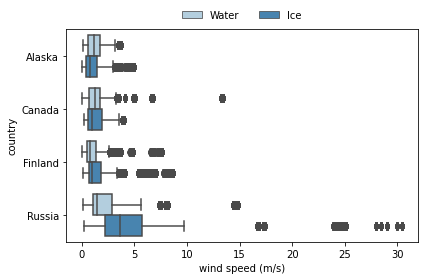

In [ ]:
country_order = ['Alaska', 'Canada', 'Finland', 'Russia']

fig, ax = plt.subplots(1,1)
sns.boxplot(y='country', x = 'windRes', hue ='iceplot', data = windan, order = country_order, palette="Blues")
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

ax.set_xlabel('wind speed (m/s)')
plt.tight_layout()

plt.show()

fig.savefig('windSpeedDistribution.png')

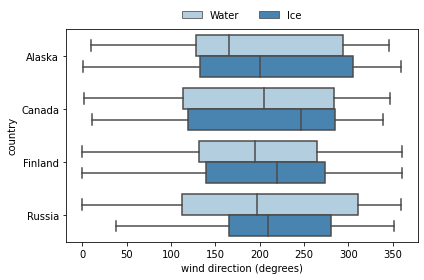

In [ ]:
country_order = ['Alaska', 'Canada', 'Finland', 'Russia']

fig, ax = plt.subplots(1,1)
sns.boxplot(y='country', x = 'windDir', hue ='iceplot', data = windan, order = country_order, palette="Blues")
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

ax.set_xlabel('wind direction (degrees)')
plt.tight_layout()

plt.show()
fig.savefig('windDirectiondistibution.png')

## GLCM features

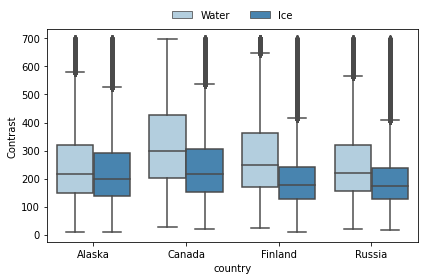

In [22]:
fig, ax = plt.subplots(1,1, figsize = (6,4), sharey=True)
country_order = ['Alaska', 'Canada', 'Finland', 'Russia']

sns.boxplot(x='country', y = 'cont', hue ='iceplot', data = tuckey, ax =ax, order = country_order, palette="Blues")
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

ax.set_ylabel('Contrast')

fig.tight_layout()
plt.show()

fig.savefig('boxplotContrast.png')

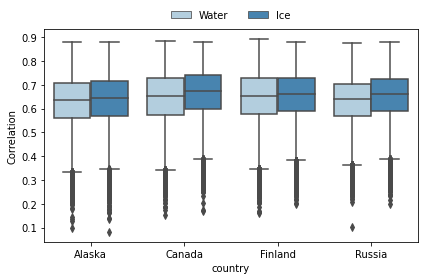

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,4), sharey=True)
country_order = ['Alaska', 'Canada', 'Finland', 'Russia']

sns.boxplot(x='country', y = 'corr', hue ='iceplot', data = tuckey, ax =ax, order = country_order, palette="Blues")
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

ax.set_ylabel('Correlation')

fig.tight_layout()
plt.show()

fig.savefig('boxplotCorrelation.png')

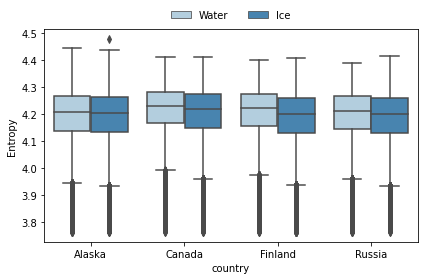

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (6,4), sharey=True)
country_order = ['Alaska', 'Canada', 'Finland', 'Russia']

sns.boxplot(x='country', y = 'ent', hue ='iceplot', data = tuckey, ax =ax, order = country_order, palette="Blues")
sns.move_legend(ax, "lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False)

ax.set_ylabel('Entropy')

fig.tight_layout()
plt.show()

fig.savefig('boxplotEntropy.png')

In [ ]:
tuckey.columns
features = ['VV', 'VH', 'angle', 'ice', 'lake', 'cont', 'corr',
       'ent', 'VVnorm', 'VVwindowVar', 'VHnorm', 'VHwindowVar', 'pixelId',
       'imgId', 'country', 'VV/VH', 'windRes',
       'windDir', 'year']
tuckeyExport = tuckey[features]

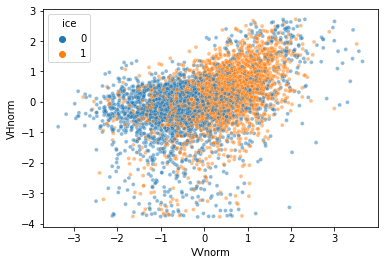

In [45]:
sns.scatterplot(data = tuckey.sample(n=5000), x = 'VVnorm', y = 'VHnorm', hue = 'ice', s = 15, alpha = .5)

In [ ]:
# export csv 
tuckey.to_csv(os.path.join(path, 'cleaned_pixel_Traindata.csv'))